In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch as t
from paren_checker import HighLevelParensBalanceChecker, BalancedParensDataset, SequentialParensDataset
from paren_checker import test_HL_parens_components
test_HL_parens_components()
balance_checker = HighLevelParensBalanceChecker()
dset = BalancedParensDataset(
        N_samples = 10,
        n_ctx = 22, #accounts for a BOS and a PAD
        seed = 42
    )
print('the markers', dset.get_dataset()['markers'])
for item in dset.get_dataset():
    output = balance_checker(t.Tensor(item['tokens'])[None,:])
    print('check: [', output[0,-1].int().item(), item['labels'], '] ', ''.join(item['str_tokens']))
    

All tests passed!
the markers [3, 1, 1, 3, 2, 0, 1, 1, 1, 2]
check: [ 0 0 ]  BOS ( ( ) ( ( ( ( ( ) ) ( ( ( ) ( ( ( ( ( ( PAD
check: [ 1 1 ]  BOS ( ( ) ) ( ) ( ) ( ( ( ) ) ( ) ) ( ( ) ) PAD
check: [ 1 1 ]  BOS ( ) ( ) ( ) ( ( ) ( ) ) ( ( ( ( ) ) ) ) PAD
check: [ 0 0 ]  BOS ( ( ( ( ( ( ) ( ( ( ( ( ) ( ( ( ( ( ) ( PAD
check: [ 0 0 ]  BOS ) ( ( ( ( ( ) ( ) ) ) ) ( ) ( ) ) ( ( ) PAD
check: [ 0 0 ]  BOS ) ) ) ) ( ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) PAD
check: [ 1 1 ]  BOS ( ) ( ( ( ( ( ) ( ( ( ) ( ) ) ) ) ) ) ) PAD
check: [ 1 1 ]  BOS ( ( ) ) ( ( ( ) ( ( ( ) ) ) ) ( ) ) ( ) PAD
check: [ 1 1 ]  BOS ( ( ) ) ( ) ( ) ( ( ) ( ( ) ) ) ( ( ) ) PAD
check: [ 0 0 ]  BOS ) ) ) ( ( ( ) ) ) ( ( ( ) ) ( ) ( ( ) ( PAD


In [4]:
from paren_checker import get_LL_parens_model_and_correspondence
ll_model, corr, unused_nodes = get_LL_parens_model_and_correspondence()
print("Model:")
print(ll_model)
print("\nCorrespondence:")
for k, i in corr.items():
    print(k, i)
print("\nUnused:")
for n in unused_nodes:
    print(n)

Model:
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (ho

In [5]:
dset = BalancedParensDataset(
        N_samples = 10_000,
        n_ctx = 42, #accounts for a BOS and a PAD
        seed = 42
    )
dataset = dset.get_dataset()
print(dataset.shape)

(10000, 4)


In [65]:
import torch as t
from siit_utils import ModelTrainerSIIT
from paren_checker import paren_checker_loss_fn as loss_fn

t.manual_seed(150) #150 for 10 epochs does pretty well; might be better at 6 epochs.
ll_model, corr, unused_nodes = get_LL_parens_model_and_correspondence(n_ctx = 42)

trainer = ModelTrainerSIIT(
    ll_model=ll_model,
    hl_model=balance_checker,
    dataset=dataset,
    corr=corr,
    unused_nodes=unused_nodes,
    loss_fn=loss_fn,
    baseline_weight = 1,
    iit_weight = 1,
    siit_weight = 1,
    batch_size = 512,
    device = 'cuda'
)
#epoch 6: iia = 1, loss = 0.0027, epoch 7: iia = 1, loss = 0.00296; epoch 8: iia=1, loss = 0.00696; epoch 9: iia=1, loss = 0.00611; epoch 10: iia=1, loss=0.00277
results = trainer.train(epochs=1000, lr=2e-2)

Moving model to device:  cuda


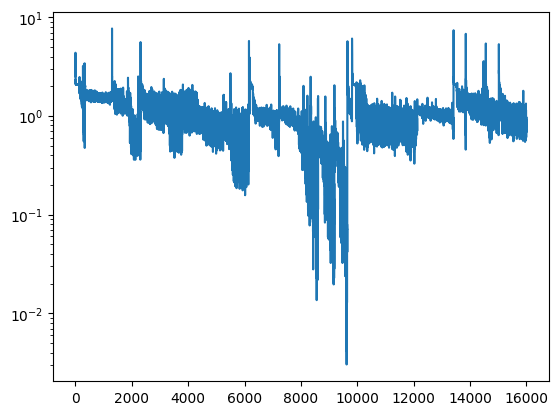

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.semilogy(results['train_loss'])
plt.show()

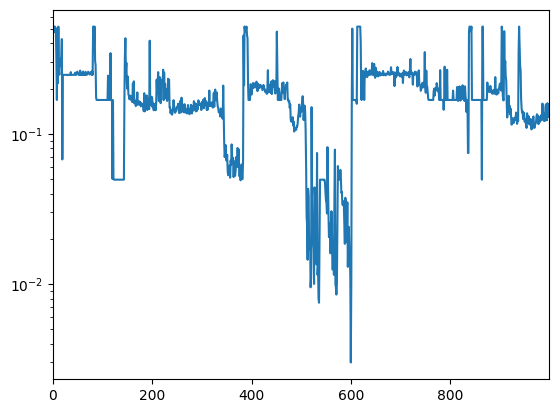

In [67]:
import numpy as np
steps = np.arange(len(np.array(results['test_siit_wrong'])))
plt.figure()
plt.semilogy(steps, np.array(results['test_siit_wrong']))
plt.xlim(0, steps.max())
plt.show()

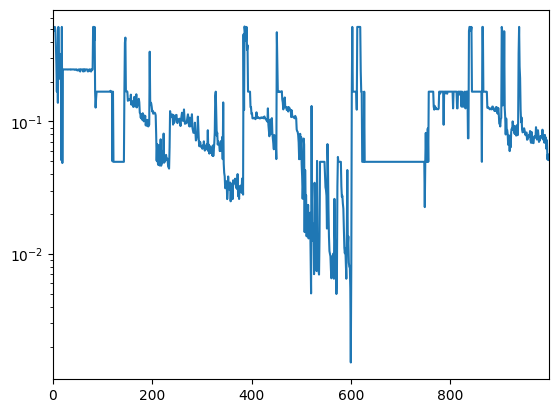

In [68]:
import numpy as np
steps = np.arange(len(np.array(results['test_IIA'])))
plt.figure()
plt.semilogy(steps, 1 - np.array(results['test_IIA']))
plt.xlim(0, steps.max())
plt.show()

In [69]:
from functools import partial
from siit_utils import make_post_ablation_hook

for method in ['zero', 'mean', 'shuffle']:
    tot = 0
    errors = 0
    ablated_errors = 0
    for b in trainer.test_dataloaders[0]:
        tokens, labels = b
        logits, cache = ll_model.run_with_cache(tokens)
        output_labels = t.round(t.sigmoid(logits)[:,-1,-1])
        sumdiff = (labels.cuda() != output_labels.float()).sum().item()
    
        hooks = []
        for node in unused_nodes:
            hooks.append((node.name, make_post_ablation_hook(ll_node=node, ll_cache=cache, method=method)))
        ablated_logits = ll_model.run_with_hooks(tokens, fwd_hooks=hooks)
        
        ablated_labels = t.round(t.sigmoid(ablated_logits)[:,-1,-1])
        ablated_sumdiff = (labels.cuda() != ablated_labels.float()).sum().item()
    
        errors += sumdiff
        ablated_errors += ablated_sumdiff
        tot += labels.numel()
    print(f'Method: {method}')
    print(f'Errors: {errors}/{tot}, Ablated Err: {ablated_errors}/{tot}\n')
        

Method: zero
Errors: 103/2000, Ablated Err: 313/2000

Method: mean
Errors: 103/2000, Ablated Err: 1035/2000

Method: shuffle
Errors: 103/2000, Ablated Err: 313/2000



In [61]:
#TODO: Add lines to save model to huggingface.

# Take a peek at the attention pattern on the important heads?

# SAEs -- vanilla

In [30]:
from paren_checker import create_paren_checker_tokenizer
tokenizer = create_paren_checker_tokenizer()
ll_model.tokenizer = tokenizer #attach to model.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Encoded: [3, 0, 1, 0, 1, 2, 2, 2]
Decoded: BOS ( ) ( ) PAD PAD PAD


In [31]:
from sae_utils import make_sae_lens_config
sae_lens_cfg = make_sae_lens_config(
    model=ll_model,
    hook_name="blocks.0.attn.hook_z", 
    hook_layer=0, 
    l1_coefficient=0.2,
    l1_warm_up_steps = 0,
    hook_head_index=0, 
    context_size=ll_model.cfg.n_ctx,
    d_in=ll_model.cfg.d_head,
    device = 'cuda',
    checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens_sae_checkpoints",
    wandb_project =  "benchmark_saes",
    training_tokens = 100_000_000,
    batch_size = 256,
)

hook_head_index 0
d_in 8
wandb_project benchmark_saes
Run name: 32-L1-0.2-LR-0.0003-Tokens-1.000e+08
n_tokens_per_buffer (millions): 0.00336
Lower bound: n_contexts_per_buffer (millions): 8e-05
Total training steps: 9300
Total wandb updates: 930
n_tokens_per_feature_sampling_window (millions): 903.168
n_tokens_per_dead_feature_window (millions): 451.584
We will reset the sparsity calculation 4 times.
Number tokens in sparsity calculation window: 2.15e+07
Using Ghost Grads.


In [32]:
from sae_utils import train_sae

#I need to be able to tell the SAE to ignore certain tokens during training.
sae, store = train_sae(ll_model, sae_lens_cfg, dataset, batch_size=256)#, ignore_tokens=[])#2, 3])

wandb: Currently logged in as: evanhanders. Use `wandb login --relogin` to force relogin


Training SAE:   0%|                                                                         | 0/100000000 [00:00<?, ?it/s]/opt/venv/lib/python3.10/site-packages/sae_lens/training/activations_store.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(
1800| MSE Loss 0.044 | L1 0.141:  19%|██████▊                            | 19353600/100000000 [01:35<06:37, 202837.13it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/dccr8n2y/20009472


3700| MSE Loss 0.033 | L1 0.127:  40%|█████████████▉                     | 39782400/100000000 [03:23<05:16, 190404.08it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/dccr8n2y/40008192


5500| MSE Loss 0.033 | L1 0.142:  59%|████████████████████▋              | 59136000/100000000 [05:01<03:23, 201183.99it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/dccr8n2y/60006912


7400| MSE Loss 0.028 | L1 0.145:  80%|███████████████████████████▊       | 79564800/100000000 [06:48<01:50, 184838.64it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/dccr8n2y/80005632


9300| MSE Loss 0.033 | L1 0.151: 100%|██████████████████████████████████▉| 99993600/100000000 [08:32<00:00, 198136.37it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/dccr8n2y/final_100004352


9300| MSE Loss 0.033 | L1 0.151: 100%|██████████████████████████████████▉| 99993600/100000000 [08:33<00:00, 194713.44it/s]


details/current_l1_coefficient,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/n_training_tokens,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
losses/auxiliary_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/ghost_grad_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/l1_loss,█▅▃▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/mse_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/overall_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/explained_variance,▁▅▆▇██▇▇▇▇████████▇██▇██████████████████
metrics/explained_variance_std,█▅▅▂▁▁▂▂▃▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂
metrics/l0,█▆▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [35]:
from sae_utils import make_token_df
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

n_activations_sum = t.zeros(sae.cfg.d_sae).to(sae.device)
input_tokens_list = []
learned_activations = []
extras_list = []
extra_hook = 'left_paren_hook'
extra_name = 'left_parens'

t_dataset = TensorDataset(
    t.tensor(dataset['tokens']).int(), 
    t.tensor(dataset['labels']).float()
)
dataloader  = DataLoader(t_dataset, batch_size=256, shuffle = False)

#go through the training dataset and get max activations for each feature
total_inputs = 0
for batch in tqdm(dataloader):
    tokens, labels = batch
    total_inputs += tokens.numel()
    logits, cache = ll_model.run_with_cache(tokens)
    sae_in = cache[sae.cfg.hook_name]
    if sae.cfg.hook_head_index is not None:
        sae_in = sae_in[:,:,sae.cfg.hook_head_index,:] #I think this is how attn head indexing works...
    activations = sae.encode(sae_in)
    # print(activations.shape, labels.shape, tokens.shape, tokens.numel())
    activations[t.isin(tokens.int(), t.Tensor([2, 3]).int())] = 0

    # For sparsity calculation
    n_new_activations = (activations > 0).sum(dim=(0,1)) #sum over batch and ctx
    n_activations_sum = n_activations_sum + n_new_activations

    # Save tokens and activations
    input_tokens_list.append(tokens.cpu())
    learned_activations.append(activations.to(t.float16).cpu().reshape(-1, sae.cfg.d_sae))

    #HL output
    hl_output, hl_cache = balance_checker.run_with_cache(tokens)
    extra = hl_cache[extra_hook]
    extras_list.append(extra.cpu())

    # if total_inputs > 100_000:
    #     break
sparsity = n_activations_sum / total_inputs
tokens = t.cat(input_tokens_list).to(int)
extras = t.cat(extras_list).to(int)
token_df = make_token_df(ll_model, tokens, len_prefix=ll_model.cfg.n_ctx, 
                         extra_token_labels={extra_name : extras})
learned_activations = t.cat(learned_activations).to(t.float16)
token_df.shape

/tmp/ipykernel_12938/718347451.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t.tensor(dataset['tokens']).int(),


tokens torch.Size([97472, 42])


(4093824, 9)

In [36]:
from transformer_lens import utils
import ipywidgets as widgets
from IPython.display import display

def update_dataframe(feature_id):
    token_df["activation"] = utils.to_numpy(learned_activations[:,feature_id])
    df = token_df[['str_tokens','prefix', 'suffix',  'context', 'activation', extra_name]]
    df = df.sort_values("activation", ascending=False).head(100)
    # display(df[df['activation'] > 0].style.background_gradient("coolwarm"))
    unique = df[['str_tokens', 'prefix', 'activation', extra_name]].drop_duplicates()
    display(unique[unique['activation'] > 0].head(100).style.background_gradient("coolwarm"))

# Define the dropdown menu for 'feat'
feat_dropdown = widgets.Dropdown(
    options=range(sae.cfg.d_sae),
    value=0,
    description='Feature:',
)

# Create an interactive output widget
output = widgets.interactive_output(
    update_dataframe, 
    {
        'feature_id': feat_dropdown,
    }
)

# Display the dropdown menu and output
display(feat_dropdown, output)



Dropdown(description='Feature:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Output()

sae for attn 0 head 0:

TBD



In [37]:
from sae_utils import make_sae_lens_config
sae_lens_cfg = make_sae_lens_config(
    model=ll_model, 
    hook_name="blocks.0.mlp.hook_post", 
    hook_layer=0, 
    l1_coefficient=0.2,
    l1_warm_up_steps = 0,
    context_size=ll_model.cfg.n_ctx,
    d_in=ll_model.cfg.d_mlp,
    device = 'cuda',
    checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens_sae_checkpoints",
    wandb_project =  "benchmark_saes",
    training_tokens = 100_000_000,
    batch_size = 256,
)

d_in 64
wandb_project benchmark_saes
Run name: 256-L1-0.2-LR-0.0003-Tokens-1.000e+08
n_tokens_per_buffer (millions): 0.00336
Lower bound: n_contexts_per_buffer (millions): 8e-05
Total training steps: 9300
Total wandb updates: 930
n_tokens_per_feature_sampling_window (millions): 903.168
n_tokens_per_dead_feature_window (millions): 451.584
We will reset the sparsity calculation 4 times.
Number tokens in sparsity calculation window: 2.15e+07
Using Ghost Grads.


In [38]:
from sae_utils import train_sae

#I need to be able to tell the SAE to ignore certain tokens during training.
sae, store = train_sae(ll_model, sae_lens_cfg, dataset)#, ignore_tokens=[])#2, 3])

Training SAE:   0%|                                                                         | 0/100000000 [00:00<?, ?it/s]/opt/venv/lib/python3.10/site-packages/sae_lens/training/activations_store.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(
1800| MSE Loss 0.214 | L1 0.991:  19%|██████▊                            | 19353600/100000000 [01:44<07:40, 175175.65it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/1ct4tqbi/20009472


3700| MSE Loss 0.196 | L1 0.907:  40%|█████████████▉                     | 39782400/100000000 [03:37<05:34, 179809.44it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/1ct4tqbi/40008192


5500| MSE Loss 0.245 | L1 0.811:  59%|████████████████████▋              | 59136000/100000000 [05:23<03:54, 174439.33it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/1ct4tqbi/60006912


7400| MSE Loss 0.189 | L1 1.034:  80%|███████████████████████████▊       | 79564800/100000000 [07:17<01:53, 179617.45it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/1ct4tqbi/80005632


9300| MSE Loss 0.121 | L1 0.773: 100%|██████████████████████████████████▉| 99993600/100000000 [09:08<00:00, 182530.46it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/1ct4tqbi/final_100004352


9300| MSE Loss 0.121 | L1 0.773: 100%|██████████████████████████████████▉| 99993600/100000000 [09:08<00:00, 182207.75it/s]


details/current_l1_coefficient,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/n_training_tokens,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
losses/auxiliary_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/ghost_grad_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/l1_loss,█▃▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/mse_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/overall_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/explained_variance,▁▆▇▇████▇█████████▇█████████████████████
metrics/explained_variance_std,█▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂
metrics/l0,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [39]:
from sae_utils import make_token_df
from torch.utils.data import DataLoader, TensorDataset


n_activations_sum = t.zeros(sae.cfg.d_sae).to(sae.device)
input_tokens_list = []
learned_activations = []
extras_list = []
extra_hook = 'elevation_hook'
extra_name = 'elevation'

t_dataset = TensorDataset(
    t.tensor(dataset['tokens']).int(), 
    t.tensor(dataset['labels']).float()
)
dataloader  = DataLoader(t_dataset, batch_size=256, shuffle = False)

#go through the training dataset and get max activations for each feature
total_inputs = 0
for batch in tqdm(dataloader):
    tokens, labels = batch
    total_inputs += tokens.numel()
    logits, cache = ll_model.run_with_cache(tokens)
    sae_in = cache[sae.cfg.hook_name]
    if sae.cfg.hook_head_index is not None:
        sae_in = sae_in[:,:,sae.cfg.hook_head_index,:] #I think this is how attn head indexing works...
    activations = sae.encode(sae_in)
    # print(activations.shape, labels.shape, tokens.shape, tokens.numel())
    activations[t.isin(tokens.int(), t.Tensor([2, 3]).int())] = 0

    # For sparsity calculation
    n_new_activations = (activations > 0).sum(dim=(0,1)) #sum over batch and ctx
    n_activations_sum = n_activations_sum + n_new_activations

    # Save tokens and activations
    input_tokens_list.append(tokens.cpu())
    learned_activations.append(activations.to(t.float16).cpu().reshape(-1, sae.cfg.d_sae))

    #HL output
    hl_output, hl_cache = balance_checker.run_with_cache(tokens)
    extra = hl_cache[extra_hook]
    extras_list.append(extra.cpu())

    # if total_inputs > 100_000:
    #     break
sparsity = n_activations_sum / total_inputs
tokens = t.cat(input_tokens_list).to(int)
extras = t.cat(extras_list).to(int)
token_df = make_token_df(ll_model, tokens, len_prefix=ll_model.cfg.n_ctx, 
                         extra_token_labels={extra_name : extras})
learned_activations = t.cat(learned_activations).to(t.float16)
token_df.shape

/tmp/ipykernel_12938/3317634938.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t.tensor(dataset['tokens']).int(),


tokens torch.Size([97472, 42])


(4093824, 9)

In [40]:
from transformer_lens import utils
import ipywidgets as widgets
from IPython.display import display

def update_dataframe(feature_id):
    token_df["activation"] = utils.to_numpy(learned_activations[:,feature_id])
    df = token_df[['str_tokens','prefix', 'suffix',  'context', 'activation', 'elevation']]
    df = df.sort_values("activation", ascending=False).head(100)
    # display(df[df['activation'] > 0].style.background_gradient("coolwarm"))
    unique = df[['str_tokens', 'prefix', 'activation', 'elevation']].drop_duplicates()
    display(unique[unique['activation'] > 0].head(100).style.background_gradient("coolwarm"))

# Define the dropdown menu for 'feat'
feat_dropdown = widgets.Dropdown(
    options=range(sae.cfg.d_sae),
    value=0,
    description='Feature:',
)

# Create an interactive output widget
output = widgets.interactive_output(
    update_dataframe, 
    {
        'feature_id': feat_dropdown,
    }
)

# Display the dropdown menu and output
display(feat_dropdown, output)



Dropdown(description='Feature:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Output()

In [1]:
import sae_lens
print(sae_lens.__version__)

3.12.1


# SAELens -- top-k

In [23]:
from sae_utils import make_topk_sae_lens_config
sae_lens_cfg = make_topk_sae_lens_config(
    model=ll_model, 
    hook_name="blocks.0.mlp.hook_post", 
    hook_layer=0, 
    k=4, #choose smallest value that achieves good mse loss.
    context_size=ll_model.cfg.n_ctx,
    d_in=ll_model.cfg.d_mlp,
    device = 'cuda',
    checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens_sae_checkpoints",
    wandb_project =  "benchmark_saes",
    training_tokens = 100_000_000,
    batch_size = 256,
)

activation_fn topk
activation_fn_kwargs {'k': 4}
mse_loss_normalization None
d_in 64
wandb_project benchmark_saes
Run name: 256-L1-0.1-LR-0.0003-Tokens-1.000e+08
n_tokens_per_buffer (millions): 0.02688
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 9300
Total wandb updates: 930
n_tokens_per_feature_sampling_window (millions): 903.168
n_tokens_per_dead_feature_window (millions): 451.584
We will reset the sparsity calculation 4 times.
Number tokens in sparsity calculation window: 2.15e+07
Using Ghost Grads.


In [24]:
from sae_utils import train_sae

#I need to be able to tell the SAE to ignore certain tokens during training.
sae, store = train_sae(ll_model, sae_lens_cfg, dataset.shuffle(seed=101))#, ignore_tokens=[])#2, 3])

details/current_l1_coefficient,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/n_training_tokens,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
losses/auxiliary_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/ghost_grad_loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/l1_loss,▁▄▇██████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
losses/mse_loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/overall_loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/explained_variance,▁▃▆▇▇▇▇▇▇███████████████████████████████
metrics/explained_variance_std,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/l0,███████████████████████████████████▅▁▄█▅




Training SAE:   0%|                                                                         | 0/100000000 [00:00<?, ?it/s]/opt/venv/lib/python3.10/site-packages/sae_lens/training/activations_store.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(
/opt/venv/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2265: UserWarning: Run (25elroub) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
1200| MSE Loss 1.594 | L1 0.940:  13%|████▍                             | 12902400/100000000 [18:41<2:06:08, 11507.49it/s]


100| MSE Loss 13.181 | L1 0.473:   0%|                                                      | 0/100000000 [00:11<?, ?it/s]

100| MSE Loss 13.181 | L1 0.473:   1%|▍               



700| MSE Loss 1.961 | L1 0.562:   6%|██▍                                   | 6451200/100000000 [01:25<17:32, 88884.25it/s]

700| MSE Loss 1.961 | L1 0.562:   8%|██▊                                   | 7526400/100000000 [01:25<17:32, 87889.39it/s]

700| MSE Loss 1.961 | L1 0.562:   8%|██▊                                   | 7526400/100000000 [01:37<17:32, 87889.39it/s]

800| MSE Loss 1.781 | L1 0.554:   8%|██▊                                   | 7526400/100000000 [01:37<17:32, 87889.39it/s]

800| MSE Loss 1.781 | L1 0.554:   9%|███▎                                  | 8601600/100000000 [01:37<17:23, 87551.24it/s]

900| MSE Loss 1.595 | L1 0.551:   9%|███▎                                  | 8601600/100000000 [01:50<17:23, 87551.24it/s]

900| MSE Loss 1.595 | L1 0.551:  10%|███▋                                  | 9676800/100000000 [01:50<17:32, 85839.06it/s]

900| MSE Loss 1.595 | L1 0.551:  10%|███▋                                  | 9676800/100000000 [02:02<17:32, 85839.06it/s]

1000| 



1200| MSE Loss 1.305 | L1 0.537:  13%|████▋                               | 12902400/100000000 [02:42<17:53, 81164.34it/s]

1300| MSE Loss 1.271 | L1 0.536:  13%|████▋                               | 12902400/100000000 [02:45<17:53, 81164.34it/s]

1300| MSE Loss 1.271 | L1 0.536:  14%|█████                               | 13977600/100000000 [02:45<17:54, 80071.11it/s]

1300| MSE Loss 1.271 | L1 0.536:  14%|█████                               | 13977600/100000000 [02:57<17:54, 80071.11it/s]

1400| MSE Loss 1.173 | L1 0.531:  14%|█████                               | 13977600/100000000 [02:57<17:54, 80071.11it/s]

1400| MSE Loss 1.173 | L1 0.531:  15%|█████▍                              | 15052800/100000000 [02:57<17:19, 81751.03it/s]

1500| MSE Loss 1.117 | L1 0.520:  15%|█████▍                              | 15052800/100000000 [03:09<17:19, 81751.03it/s]

1500| MSE Loss 1.117 | L1 0.520:  16%|█████▊                              | 16128000/100000000 [03:09<16:39, 83910.73it/s]

1600| 

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/lob29g44/20009472




1800| MSE Loss 0.988 | L1 0.515:  19%|██████▉                             | 19353600/100000000 [03:57<15:44, 85368.89it/s]

1900| MSE Loss 0.959 | L1 0.513:  19%|██████▉                             | 19353600/100000000 [04:00<15:44, 85368.89it/s]

1900| MSE Loss 0.959 | L1 0.513:  20%|███████▎                            | 20428800/100000000 [04:00<15:33, 85271.94it/s]

2000| MSE Loss 0.894 | L1 0.508:  20%|███████▎                            | 20428800/100000000 [04:12<15:33, 85271.94it/s]

2000| MSE Loss 0.894 | L1 0.508:  22%|███████▋                            | 21504000/100000000 [04:12<15:06, 86605.94it/s]

2000| MSE Loss 0.894 | L1 0.508:  22%|███████▋                            | 21504000/100000000 [04:22<15:06, 86605.94it/s]

2100| MSE Loss 0.900 | L1 0.505:  22%|███████▋                            | 21504000/100000000 [04:24<15:06, 86605.94it/s]

2100| MSE Loss 0.900 | L1 0.505:  23%|████████▏                           | 22579200/100000000 [04:24<14:52, 86775.31it/s]

2200| 



2500| MSE Loss 0.823 | L1 0.486:  26%|█████████▎                          | 25804800/100000000 [05:12<13:48, 89606.12it/s]

2500| MSE Loss 0.823 | L1 0.486:  27%|█████████▋                          | 26880000/100000000 [05:12<13:35, 89669.37it/s]

2500| MSE Loss 0.823 | L1 0.486:  27%|█████████▋                          | 26880000/100000000 [05:22<13:35, 89669.37it/s]

2600| MSE Loss 0.827 | L1 0.489:  27%|█████████▋                          | 26880000/100000000 [05:24<13:35, 89669.37it/s]

2600| MSE Loss 0.827 | L1 0.489:  28%|██████████                          | 27955200/100000000 [05:24<13:24, 89519.54it/s]

2700| MSE Loss 0.787 | L1 0.483:  28%|██████████                          | 27955200/100000000 [05:37<13:24, 89519.54it/s]

2700| MSE Loss 0.787 | L1 0.483:  29%|██████████▍                         | 29030400/100000000 [05:37<13:36, 86930.31it/s]

2700| MSE Loss 0.787 | L1 0.483:  29%|██████████▍                         | 29030400/100000000 [05:47<13:36, 86930.31it/s]

2800| 



3000| MSE Loss 0.753 | L1 0.477:  32%|███████████▌                        | 32256000/100000000 [06:28<13:46, 81973.37it/s]

3100| MSE Loss 0.755 | L1 0.475:  32%|███████████▌                        | 32256000/100000000 [06:31<13:46, 81973.37it/s]

3100| MSE Loss 0.755 | L1 0.475:  33%|███████████▉                        | 33331200/100000000 [06:31<13:46, 80690.03it/s]

3100| MSE Loss 0.755 | L1 0.475:  33%|███████████▉                        | 33331200/100000000 [06:42<13:46, 80690.03it/s]

3200| MSE Loss 0.719 | L1 0.466:  33%|███████████▉                        | 33331200/100000000 [06:44<13:46, 80690.03it/s]

3200| MSE Loss 0.719 | L1 0.466:  34%|████████████▍                       | 34406400/100000000 [06:44<13:31, 80820.81it/s]

3300| MSE Loss 0.727 | L1 0.469:  34%|████████████▍                       | 34406400/100000000 [06:57<13:31, 80820.81it/s]

3300| MSE Loss 0.727 | L1 0.469:  35%|████████████▊                       | 35481600/100000000 [06:57<13:09, 81711.59it/s]

3300| 



3700| MSE Loss 0.699 | L1 0.464:  39%|█████████████▉                      | 38707200/100000000 [07:45<11:50, 86307.83it/s]

3700| MSE Loss 0.699 | L1 0.464:  40%|██████████████▎                     | 39782400/100000000 [07:45<11:26, 87701.29it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/lob29g44/40008192




3800| MSE Loss 0.665 | L1 0.459:  40%|██████████████▎                     | 39782400/100000000 [07:57<11:26, 87701.29it/s]

3800| MSE Loss 0.665 | L1 0.459:  41%|██████████████▋                     | 40857600/100000000 [07:57<11:10, 88170.95it/s]

3800| MSE Loss 0.665 | L1 0.459:  41%|██████████████▋                     | 40857600/100000000 [08:08<11:10, 88170.95it/s]

3900| MSE Loss 0.660 | L1 0.451:  41%|██████████████▋                     | 40857600/100000000 [08:09<11:10, 88170.95it/s]

3900| MSE Loss 0.660 | L1 0.451:  42%|███████████████                     | 41932800/100000000 [08:09<10:53, 88913.49it/s]

4000| MSE Loss 0.660 | L1 0.458:  42%|███████████████                     | 41932800/100000000 [08:21<10:53, 88913.49it/s]

4000| MSE Loss 0.660 | L1 0.458:  43%|███████████████▍                    | 43008000/100000000 [08:21<10:31, 90316.17it/s]

4100| MSE Loss 0.642 | L1 0.460:  43%|███████████████▍                    | 43008000/100000000 [08:32<10:31, 90316.17it/s]

4100| 



4300| MSE Loss 0.633 | L1 0.455:  45%|████████████████▎                   | 45158400/100000000 [08:54<09:46, 93546.74it/s]

4300| MSE Loss 0.633 | L1 0.455:  46%|████████████████▋                   | 46233600/100000000 [08:54<09:32, 93915.75it/s]

4400| MSE Loss 0.619 | L1 0.454:  46%|████████████████▋                   | 46233600/100000000 [09:05<09:32, 93915.75it/s]

4400| MSE Loss 0.619 | L1 0.454:  47%|█████████████████                   | 47308800/100000000 [09:05<09:11, 95511.91it/s]

4500| MSE Loss 0.641 | L1 0.457:  47%|█████████████████                   | 47308800/100000000 [09:17<09:11, 95511.91it/s]

4500| MSE Loss 0.641 | L1 0.457:  48%|█████████████████▍                  | 48384000/100000000 [09:17<09:07, 94255.31it/s]

4500| MSE Loss 0.641 | L1 0.457:  48%|█████████████████▍                  | 48384000/100000000 [09:28<09:07, 94255.31it/s]

4600| MSE Loss 0.607 | L1 0.452:  48%|█████████████████▍                  | 48384000/100000000 [09:29<09:07, 94255.31it/s]

4600| 



4800| MSE Loss 0.598 | L1 0.451:  52%|██████████████████▌                 | 51609600/100000000 [10:08<09:18, 86650.86it/s]

4900| MSE Loss 0.563 | L1 0.445:  52%|██████████████████▌                 | 51609600/100000000 [10:09<09:18, 86650.86it/s]

4900| MSE Loss 0.563 | L1 0.445:  53%|██████████████████▉                 | 52684800/100000000 [10:09<09:14, 85325.37it/s]

5000| MSE Loss 0.553 | L1 0.450:  53%|██████████████████▉                 | 52684800/100000000 [10:21<09:14, 85325.37it/s]

5000| MSE Loss 0.553 | L1 0.450:  54%|███████████████████▎                | 53760000/100000000 [10:21<09:03, 85045.65it/s]

5000| MSE Loss 0.553 | L1 0.450:  54%|███████████████████▎                | 53760000/100000000 [10:33<09:03, 85045.65it/s]

5100| MSE Loss 0.552 | L1 0.447:  54%|███████████████████▎                | 53760000/100000000 [10:34<09:03, 85045.65it/s]

5100| MSE Loss 0.552 | L1 0.447:  55%|███████████████████▋                | 54835200/100000000 [10:34<08:54, 84527.42it/s]

5200| 



5500| MSE Loss 0.541 | L1 0.446:  58%|████████████████████▉               | 58060800/100000000 [11:22<07:55, 88238.90it/s]

5500| MSE Loss 0.541 | L1 0.446:  59%|█████████████████████▎              | 59136000/100000000 [11:22<07:30, 90785.33it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/lob29g44/60006912




5600| MSE Loss 0.509 | L1 0.447:  59%|█████████████████████▎              | 59136000/100000000 [11:33<07:30, 90785.33it/s]

5600| MSE Loss 0.509 | L1 0.447:  60%|█████████████████████▋              | 60211200/100000000 [11:33<07:12, 92047.34it/s]

5600| MSE Loss 0.509 | L1 0.447:  60%|█████████████████████▋              | 60211200/100000000 [11:44<07:12, 92047.34it/s]

5700| MSE Loss 0.541 | L1 0.445:  60%|█████████████████████▋              | 60211200/100000000 [11:44<07:12, 92047.34it/s]

5700| MSE Loss 0.541 | L1 0.445:  61%|██████████████████████              | 61286400/100000000 [11:44<06:55, 93080.81it/s]

5800| MSE Loss 0.522 | L1 0.443:  61%|██████████████████████              | 61286400/100000000 [11:56<06:55, 93080.81it/s]

5800| MSE Loss 0.522 | L1 0.443:  62%|██████████████████████▍             | 62361600/100000000 [11:56<06:42, 93502.05it/s]

5900| MSE Loss 0.505 | L1 0.442:  62%|██████████████████████▍             | 62361600/100000000 [12:07<06:42, 93502.05it/s]

5900| 



6000| MSE Loss 0.498 | L1 0.438:  65%|███████████████████████▏            | 64512000/100000000 [12:28<06:12, 95200.79it/s]

6100| MSE Loss 0.505 | L1 0.443:  65%|███████████████████████▏            | 64512000/100000000 [12:29<06:12, 95200.79it/s]

6100| MSE Loss 0.505 | L1 0.443:  66%|███████████████████████▌            | 65587200/100000000 [12:29<06:00, 95391.63it/s]

6200| MSE Loss 0.514 | L1 0.445:  66%|███████████████████████▌            | 65587200/100000000 [12:40<06:00, 95391.63it/s]

6200| MSE Loss 0.514 | L1 0.445:  67%|███████████████████████▉            | 66662400/100000000 [12:40<05:47, 95867.79it/s]

6300| MSE Loss 0.494 | L1 0.446:  67%|███████████████████████▉            | 66662400/100000000 [12:51<05:47, 95867.79it/s]

6300| MSE Loss 0.494 | L1 0.446:  68%|████████████████████████▍           | 67737600/100000000 [12:51<05:33, 96645.22it/s]

6400| MSE Loss 0.496 | L1 0.444:  68%|████████████████████████▍           | 67737600/100000000 [13:03<05:33, 96645.22it/s]

6400| 



6600| MSE Loss 0.494 | L1 0.438:  71%|█████████████████████████▌          | 70963200/100000000 [13:38<05:13, 92541.03it/s]

6700| MSE Loss 0.476 | L1 0.435:  71%|█████████████████████████▌          | 70963200/100000000 [13:40<05:13, 92541.03it/s]

6700| MSE Loss 0.476 | L1 0.435:  72%|█████████████████████████▉          | 72038400/100000000 [13:40<05:12, 89582.05it/s]

6800| MSE Loss 0.473 | L1 0.434:  72%|█████████████████████████▉          | 72038400/100000000 [13:51<05:12, 89582.05it/s]

6800| MSE Loss 0.473 | L1 0.434:  73%|██████████████████████████▎         | 73113600/100000000 [13:51<04:58, 90112.68it/s]

6900| MSE Loss 0.476 | L1 0.439:  73%|██████████████████████████▎         | 73113600/100000000 [14:03<04:58, 90112.68it/s]

6900| MSE Loss 0.476 | L1 0.439:  74%|██████████████████████████▋         | 74188800/100000000 [14:03<04:45, 90532.05it/s]

6900| MSE Loss 0.476 | L1 0.439:  74%|██████████████████████████▋         | 74188800/100000000 [14:14<04:45, 90532.05it/s]

7000| 



7200| MSE Loss 0.469 | L1 0.433:  77%|███████████████████████████▊        | 77414400/100000000 [14:49<04:06, 91638.37it/s]

7300| MSE Loss 0.484 | L1 0.442:  77%|███████████████████████████▊        | 77414400/100000000 [14:49<04:06, 91638.37it/s]

7300| MSE Loss 0.484 | L1 0.442:  78%|████████████████████████████▎       | 78489600/100000000 [14:49<03:51, 92914.00it/s]

7400| MSE Loss 0.455 | L1 0.434:  78%|████████████████████████████▎       | 78489600/100000000 [15:00<03:51, 92914.00it/s]

7400| MSE Loss 0.455 | L1 0.434:  80%|████████████████████████████▋       | 79564800/100000000 [15:00<03:32, 96316.98it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/lob29g44/80005632




7500| MSE Loss 0.453 | L1 0.431:  80%|████████████████████████████▋       | 79564800/100000000 [15:11<03:32, 96316.98it/s]

7500| MSE Loss 0.453 | L1 0.431:  81%|█████████████████████████████       | 80640000/100000000 [15:11<03:22, 95834.02it/s]

7600| MSE Loss 0.467 | L1 0.436:  81%|█████████████████████████████       | 80640000/100000000 [15:22<03:22, 95834.02it/s]

7600| MSE Loss 0.467 | L1 0.436:  82%|█████████████████████████████▍      | 81715200/100000000 [15:22<03:08, 96930.14it/s]

7700| MSE Loss 0.445 | L1 0.434:  82%|█████████████████████████████▍      | 81715200/100000000 [15:33<03:08, 96930.14it/s]

7700| MSE Loss 0.445 | L1 0.434:  83%|█████████████████████████████▊      | 82790400/100000000 [15:33<02:57, 96825.48it/s]

7800| MSE Loss 0.456 | L1 0.438:  83%|█████████████████████████████▊      | 82790400/100000000 [15:44<02:57, 96825.48it/s]

7800| MSE Loss 0.456 | L1 0.438:  84%|██████████████████████████████▏     | 83865600/100000000 [15:44<02:45, 97331.33it/s]



7800| MSE Loss 0.456 | L1 0.438:  84%|██████████████████████████████▏     | 83865600/100000000 [15:54<02:45, 97331.33it/s]

7900| MSE Loss 0.456 | L1 0.440:  84%|██████████████████████████████▏     | 83865600/100000000 [15:55<02:45, 97331.33it/s]

7900| MSE Loss 0.456 | L1 0.440:  85%|██████████████████████████████▌     | 84940800/100000000 [15:55<02:35, 97121.88it/s]

8000| MSE Loss 0.449 | L1 0.440:  85%|██████████████████████████████▌     | 84940800/100000000 [16:06<02:35, 97121.88it/s]

8000| MSE Loss 0.449 | L1 0.440:  86%|██████████████████████████████▉     | 86016000/100000000 [16:06<02:23, 97583.59it/s]

8100| MSE Loss 0.431 | L1 0.431:  86%|██████████████████████████████▉     | 86016000/100000000 [16:16<02:23, 97583.59it/s]

8100| MSE Loss 0.431 | L1 0.431:  87%|███████████████████████████████▎    | 87091200/100000000 [16:16<02:10, 98836.45it/s]

8200| MSE Loss 0.424 | L1 0.432:  87%|███████████████████████████████▎    | 87091200/100000000 [16:28<02:10, 98836.45it/s]

8200| 



8500| MSE Loss 0.419 | L1 0.434:  90%|████████████████████████████████▌   | 90316800/100000000 [17:04<01:43, 93839.07it/s]

8500| MSE Loss 0.419 | L1 0.434:  91%|████████████████████████████████▉   | 91392000/100000000 [17:04<01:34, 91352.07it/s]

8500| MSE Loss 0.419 | L1 0.434:  91%|████████████████████████████████▉   | 91392000/100000000 [17:15<01:34, 91352.07it/s]

8600| MSE Loss 0.398 | L1 0.427:  91%|████████████████████████████████▉   | 91392000/100000000 [17:16<01:34, 91352.07it/s]

8600| MSE Loss 0.398 | L1 0.427:  92%|█████████████████████████████████▎  | 92467200/100000000 [17:16<01:23, 90214.74it/s]

8700| MSE Loss 0.392 | L1 0.431:  92%|█████████████████████████████████▎  | 92467200/100000000 [17:28<01:23, 90214.74it/s]

8700| MSE Loss 0.392 | L1 0.431:  94%|█████████████████████████████████▋  | 93542400/100000000 [17:28<01:11, 90114.98it/s]

8700| MSE Loss 0.392 | L1 0.431:  94%|█████████████████████████████████▋  | 93542400/100000000 [17:39<01:11, 90114.98it/s]

8800| 



9000| MSE Loss 0.409 | L1 0.432:  97%|██████████████████████████████████▊ | 96768000/100000000 [18:15<00:35, 90256.80it/s]

9100| MSE Loss 0.404 | L1 0.427:  97%|██████████████████████████████████▊ | 96768000/100000000 [18:16<00:35, 90256.80it/s]

9100| MSE Loss 0.404 | L1 0.427:  98%|███████████████████████████████████▏| 97843200/100000000 [18:16<00:23, 89908.96it/s]

9200| MSE Loss 0.395 | L1 0.425:  98%|███████████████████████████████████▏| 97843200/100000000 [18:26<00:23, 89908.96it/s]

9200| MSE Loss 0.395 | L1 0.425:  99%|███████████████████████████████████▌| 98918400/100000000 [18:26<00:11, 92681.74it/s]

9300| MSE Loss 0.398 | L1 0.429:  99%|███████████████████████████████████▌| 98918400/100000000 [18:37<00:11, 92681.74it/s]

9300| MSE Loss 0.398 | L1 0.429: 100%|███████████████████████████████████▉| 99993600/100000000 [18:37<00:00, 93958.42it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/lob29g44/final_100004352


9300| MSE Loss 0.398 | L1 0.429: 100%|███████████████████████████████████▉| 99993600/100000000 [18:38<00:00, 89389.85it/s]


details/current_l1_coefficient,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/n_training_tokens,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
losses/auxiliary_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/ghost_grad_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/l1_loss,▁█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
losses/mse_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/overall_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/explained_variance,▁▆▇▇▇███████████████████████████████████
metrics/explained_variance_std,█▅▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/l0,█████████████▆█▅▆█▆▄▆█▃▅▅▇▁▄▁▃▃▂▄▃▃▃▃▃▃▄


# SAELens -- gated

In [29]:
from sae_utils import make_gated_sae_lens_config

#seems a lot better than top-k in terms of L0 and MSE.
sae_lens_cfg = make_gated_sae_lens_config(
    model=ll_model, 
    hook_name="blocks.0.mlp.hook_post", 
    hook_layer=0, 
    l1_coefficient=0.2,
    l1_warm_up_steps = 0,
    context_size=ll_model.cfg.n_ctx,
    d_in=ll_model.cfg.d_mlp,
    device = 'cuda',
    checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens_sae_checkpoints",
    wandb_project =  "benchmark_saes",
    training_tokens = 100_000_000,
    batch_size = 256,
)

architecture gated
use_ghost_grads False
d_in 64
wandb_project benchmark_saes
Run name: 256-L1-0.2-LR-0.0003-Tokens-1.000e+08
n_tokens_per_buffer (millions): 0.02688
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 9300
Total wandb updates: 930
n_tokens_per_feature_sampling_window (millions): 903.168
n_tokens_per_dead_feature_window (millions): 451.584
We will reset the sparsity calculation 4 times.
Number tokens in sparsity calculation window: 2.15e+07


In [ ]:
from sae_utils import train_sae

sae, store = train_sae(ll_model, sae_lens_cfg, dataset.shuffle(seed=101))

details/current_l1_coefficient,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/n_training_tokens,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
losses/auxiliary_reconstruction_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/ghost_grad_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/l1_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/overall_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/explained_variance,▁▇██████████████████████████████████████
metrics/explained_variance_std,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/l0,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁



Training SAE:   0%|                                                                         | 0/100000000 [00:00<?, ?it/s]/opt/venv/lib/python3.10/site-packages/sae_lens/training/activations_store.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(

100| MSE Loss 2.448 | L1 4.634:   0%|                                                       | 0/100000000 [00:10<?, ?it/s]
100| MSE Loss 2.448 | L1 4.634:   1%|▍                                    | 1075200/100000000 [00:10<15:49, 104151.21it/s]
200| MSE Loss 0.694 | L1 2.562:   1%|▍                                    | 1075200/100000000 [00:21<15:49, 104151.21it/s]
200| MSE Loss 0.694 | L1 2.562:   2%|▊                                    | 2150400/100000000 [00:21<16:07, 101136.19it/s]
300| MSE Loss 0.416 | L1 2.088:   2%|▊                                    | 2150400


700| MSE Loss 0.197 | L1 1.472:   6%|██▍                                   | 6451200/100000000 [01:18<16:37, 93823.92it/s]
700| MSE Loss 0.197 | L1 1.472:   8%|██▊                                   | 7526400/100000000 [01:18<16:37, 92669.41it/s]
700| MSE Loss 0.197 | L1 1.472:   8%|██▊                                   | 7526400/100000000 [01:29<16:37, 92669.41it/s]
800| MSE Loss 0.186 | L1 1.409:   8%|██▊                                   | 7526400/100000000 [01:30<16:37, 92669.41it/s]
800| MSE Loss 0.186 | L1 1.409:   9%|███▎                                  | 8601600/100000000 [01:30<16:36, 91726.82it/s]